Define useful boilerplate functions

In [ ]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

torch.set_grad_enabled(False);

2.6.0+cu124 True


In [ ]:
import torchvision.transforms as T

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [ ]:
def filter_bboxes_from_outputs(outputs,
                               threshold=0.7):
  person_class_index = 1
  # keep only predictions with confidence above threshold
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  scores, labels = probas.max(-1)
  keep = (scores > threshold) & (labels == person_class_index)

  probas_to_keep = probas[keep]

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

  return probas_to_keep, bboxes_scaled

In [ ]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A',
    'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A',
    'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A',
    'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A',
    'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A',
    'N/A', 'N/A', 'N/A', 'N/A', 'N/A',
    'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A',
    'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A',
    'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A',
    'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A',
    'N/A', 'N/A', 'N/A', 'tv', 'N/A', 'N/A', 'N/A', 'N/A',
    'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A',
    'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A',
    'N/A'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [ ]:
import matplotlib.pyplot as plt

def plot_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

Load an image for a demo

In [ ]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval();

Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]
Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from PIL import Image
import requests
im = '/content/drive/MyDrive/peddet_1.jpg'


#url = 'http://images.cocodataset.org/train2017/000000310645.jpg'
#im = Image.open(requests.get(url, stream=True).raw)


In [ ]:
from PIL import Image
im = Image.open('/content/drive/MyDrive/peddet_1.jpg').convert("RGB")

In [ ]:
#im_resized = im.resize((640, 480))

In [ ]:
#import numpy as np

#im_array = np.array(im_resized)
#print(im_array.shape)




In [ ]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)


In [ ]:
print(img.shape)


torch.Size([1, 3, 800, 1422])


In [ ]:

# propagate through the model
with torch.no_grad():
  outputs = model(img)

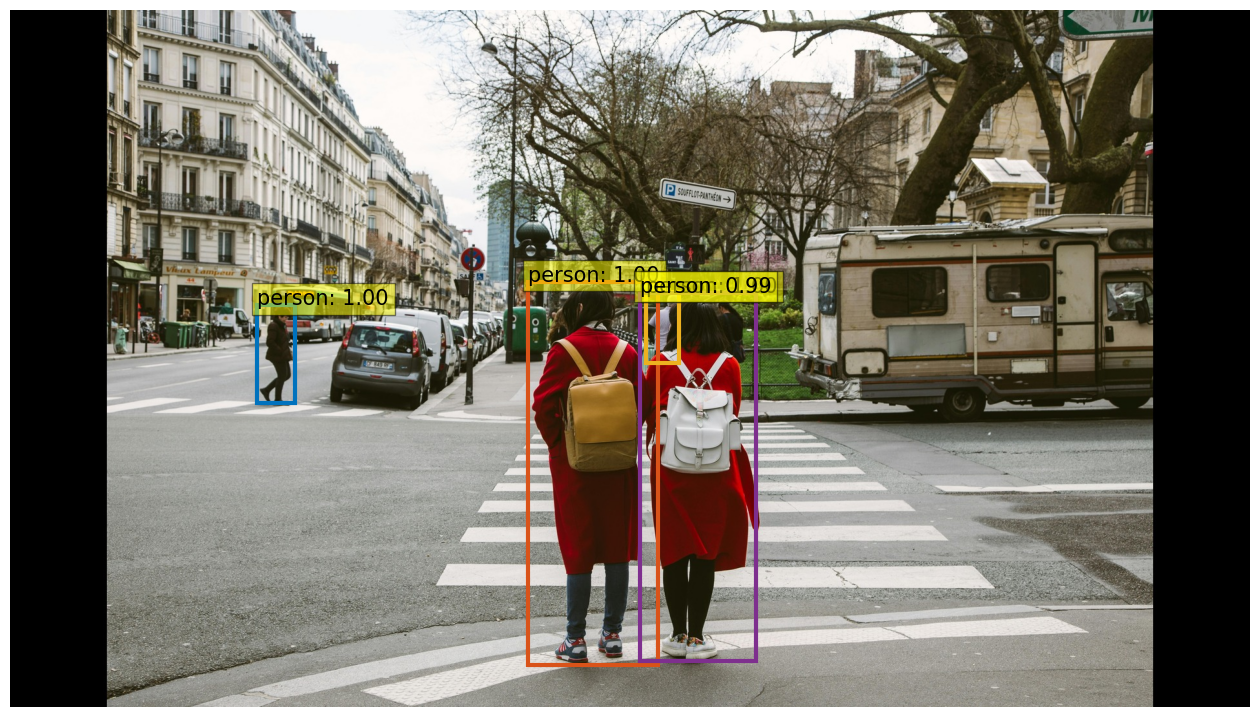

In [ ]:
for threshold in [0.9]:

  probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                            threshold=threshold)

  plot_results(im, probas_to_keep, bboxes_scaled)

In [ ]:

probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]  # remove no-object class
pred_classes = probas.argmax(-1)

# Find indices of valid (non-"N/A") classes
valid_class_ids = [i for i, c in enumerate(CLASSES) if c != 'N/A']
valid_class_ids = torch.tensor(valid_class_ids)

# Get mask for class ∈ valid_class_ids
is_valid_class = torch.isin(pred_classes, valid_class_ids)

# Confidence mask
is_confident = probas.max(-1).values > 0.9

# Combine both
keep = is_valid_class & is_confident




In [ ]:
# use lists to store the outputs via up-values
conv_features, enc_attn_weights, dec_attn_weights = [], [], []

hooks = [
    model.backbone[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        lambda self, input, output: enc_attn_weights.append(output[1])
    ),
    model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[1])
    ),
]

# propagate through the model
outputs = model(img)

for hook in hooks:
    hook.remove()

# don't need the list anymore
conv_features = conv_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights[0]

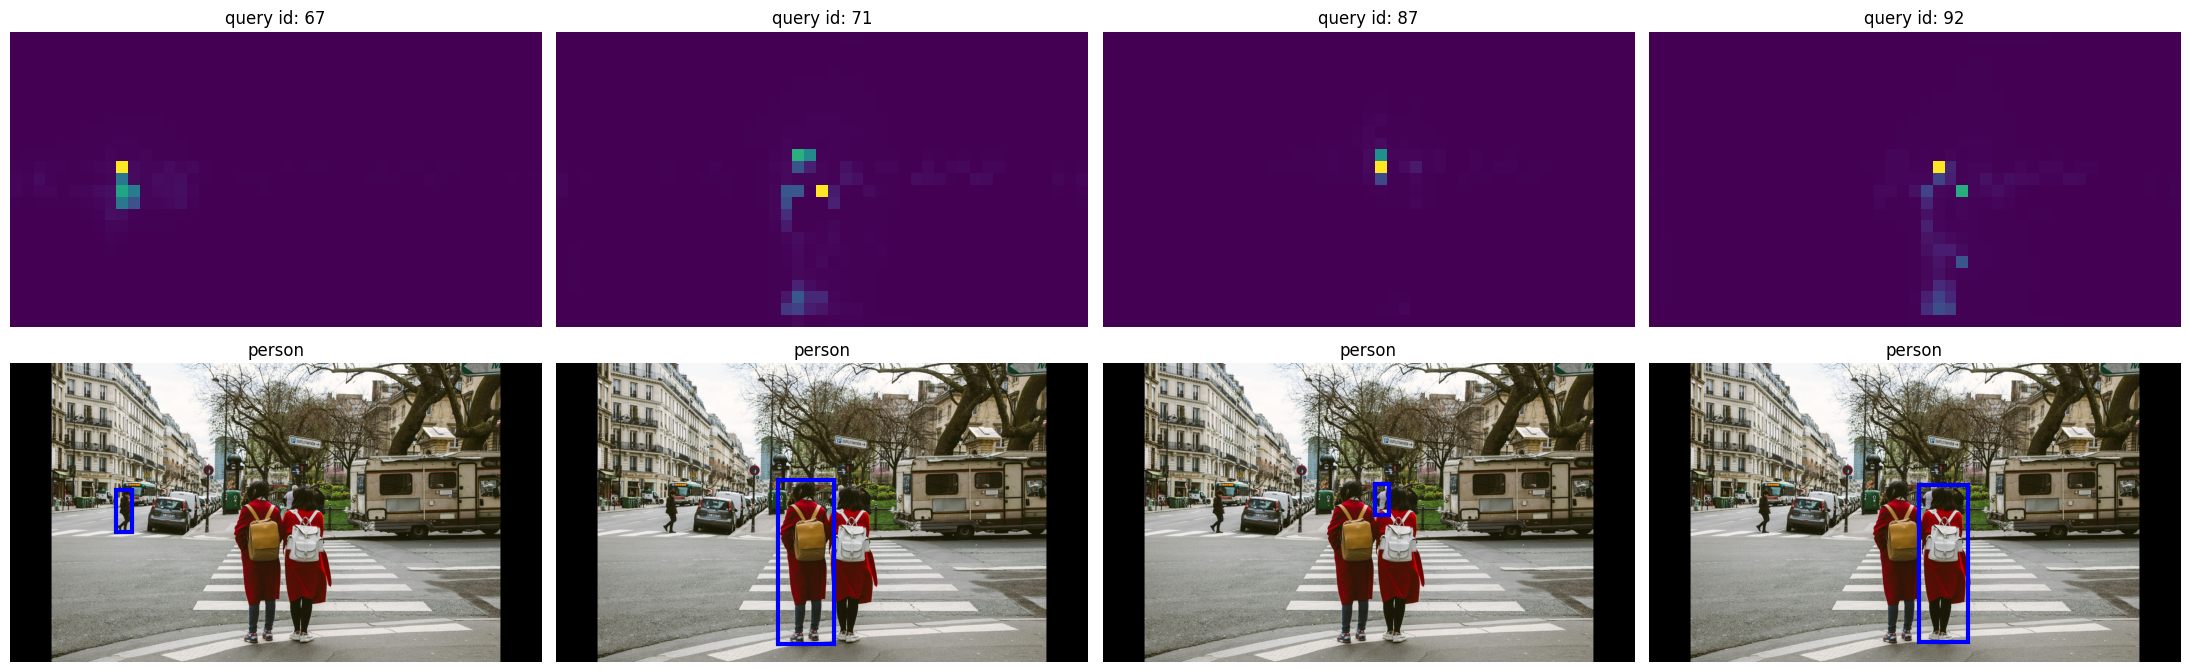

In [ ]:
# get the feature map shape
h, w = conv_features['0'].tensors.shape[-2:]

fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22, 7))

#  Make sure axs is always a 2D array
if len(bboxes_scaled) == 1:
    axs = axs.reshape(2, 1)

colors = COLORS * 100
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
    ax = ax_i[0]
    ax.imshow(dec_attn_weights[0, idx].view(h, w))
    ax.axis('off')
    ax.set_title(f'query id: {idx.item()}')

    ax = ax_i[1]
    ax.imshow(im)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                               fill=False, color='blue', linewidth=3))
    ax.axis('off')
    ax.set_title(CLASSES[probas[idx].argmax()])

fig.tight_layout()


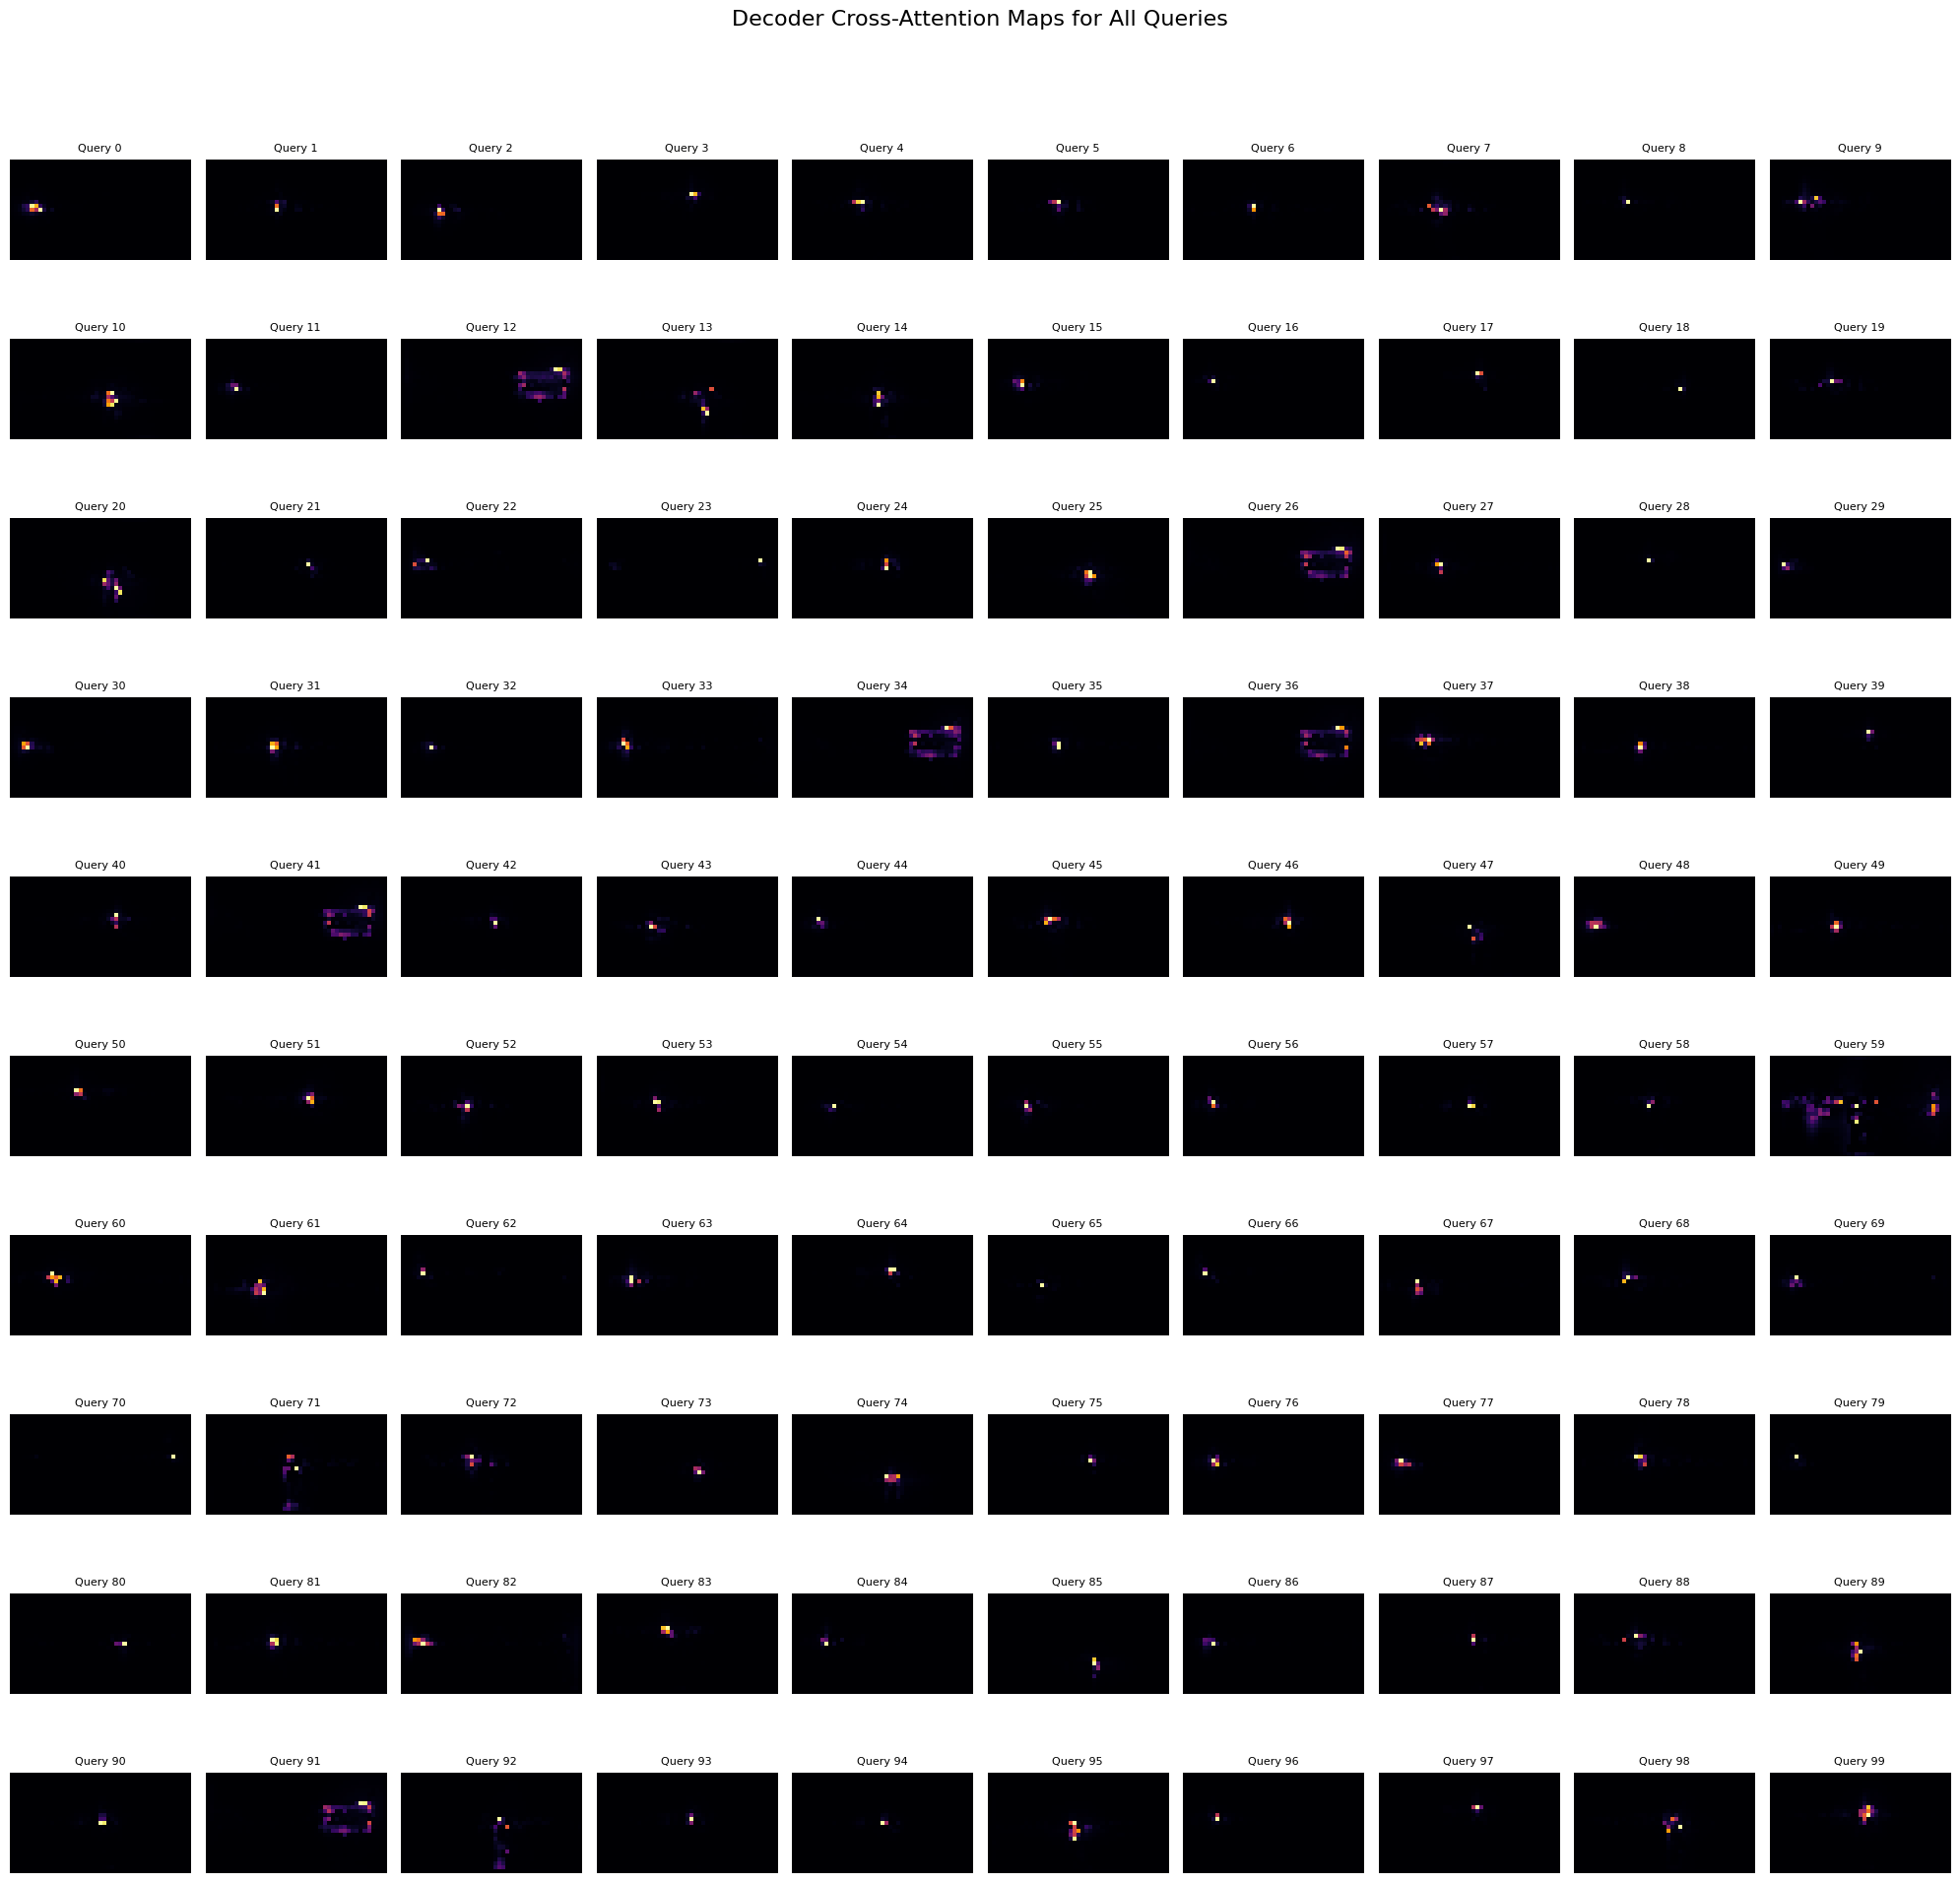

In [ ]:
# Get feature map height and width
h, w = conv_features['0'].tensors.shape[-2:]

# Number of queries used by the model (usually 100)
num_queries = dec_attn_weights.shape[1]

# Set up plot: let's do 10 rows × 10 columns = 100 queries
fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(20, 20))

for idx in range(num_queries):
    ax = axs[idx // 10, idx % 10]  # get the correct subplot

    attn_map = dec_attn_weights[0, idx].view(h, w).cpu().detach()
    ax.imshow(attn_map, cmap='inferno')
    ax.axis('off')
    ax.set_title(f'Query {idx}', fontsize=8)

fig.suptitle("Decoder Cross-Attention Maps for All Queries", fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.93)


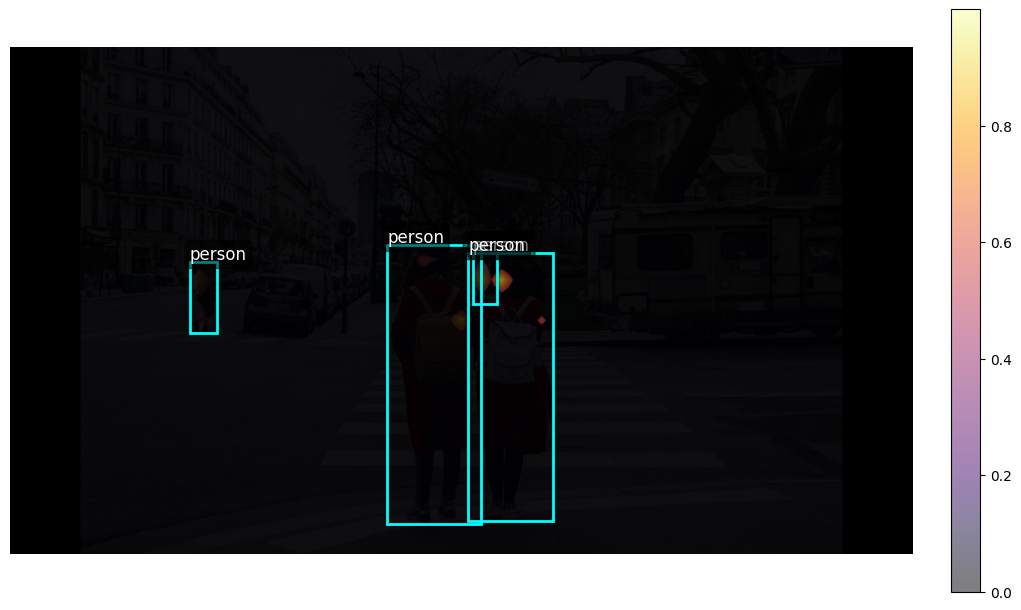

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from matplotlib.patches import Rectangle

# Convert PIL image to NumPy array if not already
im_np = np.array(im)

# Create plot and show the original image
fig, ax = plt.subplots(figsize=(10, 7))
ax.imshow(im_np)

# Overlay attention maps for detected queries
for idx, (xmin, ymin, xmax, ymax) in zip(keep.nonzero().squeeze(1), bboxes_scaled):
    # Extract and resize attention map
    attn_map = dec_attn_weights[0, idx].view(h, w).cpu().numpy()
    attn_resized = cv2.resize(attn_map, im_np.shape[1::-1])  # Resize to image size (W, H)

    # Normalize the attention map to [0, 1]
    attn_norm = (attn_resized - attn_resized.min()) / (attn_resized.max() - attn_resized.min() + 1e-6)

    # (Optional) Apply threshold to suppress low attention
    attn_thresh = np.where(attn_norm > 0.5, attn_norm, 0)  # You can adjust threshold value

    # Overlay the attention map
    attn_display = ax.imshow(attn_thresh, cmap='inferno', alpha=0.5)

    # Draw predicted bounding box
    ax.add_patch(Rectangle(
        (xmin, ymin), xmax - xmin, ymax - ymin,
        fill=False, color='cyan', linewidth=2
    ))

    # Show predicted label
    label = CLASSES[probas[idx].argmax()]
    ax.text(xmin, ymin - 5, label, color='white', fontsize=12,
            bbox=dict(facecolor='black', alpha=0.5, boxstyle='round'))

ax.axis('off')
plt.tight_layout()

fig.colorbar(attn_display, ax=ax, fraction=0.03, pad=0.04)

plt.show()
